### PHYSICAL REVIEW LETTERS 122, 047702 (2019) results:

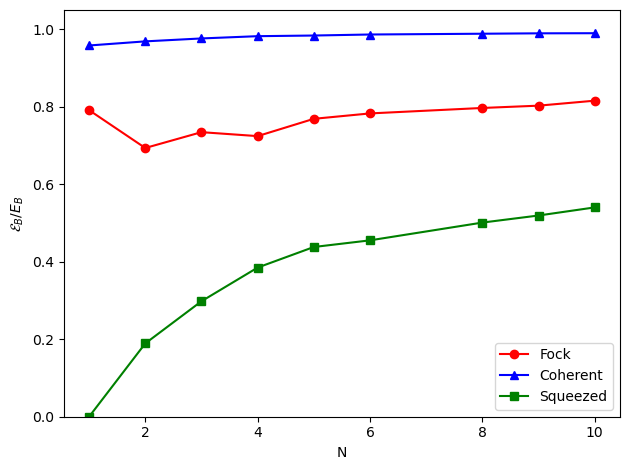

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt


def ergotropy(rho, H):
    r = np.sort(rho.eigenenergies())[::-1]
    e = np.sort(H.eigenenergies())
    return qt.expect(H, rho) - np.sum(r * e)


def collective_ops(N):
    sp, sm, I = qt.sigmap(), qt.sigmam(), qt.qeye(2)
    Sp = qt.jmat(N/2,'+')
    Sm = Sp.dag()
    Sz = qt.jmat(N/2,'z')
    HB = Sz+N/2*qt.qeye(N+1)
    return Sp, Sm, HB


def simulate_N(N, kind):
    nmax = 20
    a = qt.destroy(nmax)

    Sp, Sm, HB = collective_ops(N)
    IB = qt.qeye(N+1)

    H = (qt.tensor(a.dag()*a, IB)
       + qt.tensor(qt.qeye(nmax), HB)
       + qt.tensor(a, Sp)
       + qt.tensor(a.dag(), Sm))

    if kind == "fock":
        psiA = qt.basis(nmax, N)
    elif kind == "coherent":
        psiA = qt.coherent(nmax, np.sqrt(N))
    elif kind == "squeezed":
        psiA = qt.squeeze(nmax, np.arcsinh(np.sqrt(N))) * qt.basis(nmax, 0)

    psiB0 = qt.basis(N+1,N)
    psi0 = qt.tensor(psiA, psiB0)

    t = np.pi/np.sqrt(N)
    tlist = np.linspace(0,t,100)
    eops = qt.tensor(qt.qeye(nmax), HB)
    sol = qt.mesolve(H, psi0, tlist,e_ops=eops)
    Eblist = np.transpose(sol.expect).ravel()
    power = Eblist[1:-1]/tlist[1:-1]
    indx = np.argmax(power)
    t = tlist[indx]
    rho = qt.mesolve(H, psi0, [0, t]).states[-1]
    rhoB = rho.ptrace(1)
    
    return ergotropy(rhoB, HB) / qt.expect(HB, rhoB)


Ns = [1, 2, 3, 4, 5, 6, 8, 9, 10]
states = ["fock", "coherent", "squeezed"]

data = {s: [simulate_N(N, s) for N in Ns] for s in states}

plt.plot(Ns, data["fock"], "o-", color='red', label="Fock")
plt.plot(Ns, data["coherent"], "^-", color='blue', label="Coherent")
plt.plot(Ns, data["squeezed"], "s-",color='green', label="Squeezed")
plt.xlabel("N")
plt.ylabel(r"$\mathcal{E}_B / E_B$")
plt.legend(loc='lower right')
plt.tight_layout()
plt.ylim(0,1.05)
plt.show()

/opt/anaconda3/lib/python3.13/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/var/folders/mz/8z6t7nxj1rzg2jvg9_6hk8km0000gn/T/ipykernel_5544/2887021538.py:67: RuntimeWarning: invalid value encountered in divide
  ratio = erg / EB


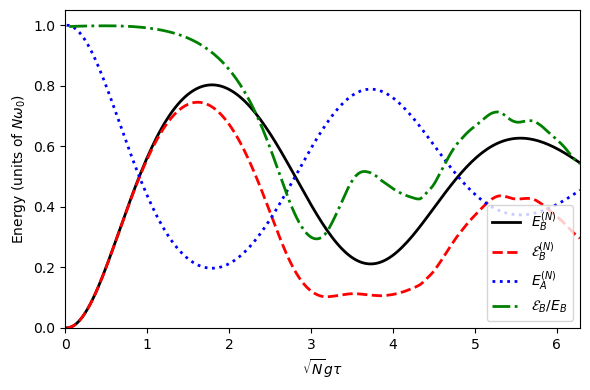

In [2]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# -----------------------
# Parameters
# -----------------------
N     = 9
j     = N/2
g     = 1.0
w0    = 1.0
nmax  = 20
tlist = np.linspace(0.005, 2*np.pi/np.sqrt(N), 200)

# -----------------------
# Operators
# -----------------------
a  = qt.destroy(nmax)
Sp = qt.jmat(j, '+')
Sm = Sp.dag()
Sz = qt.jmat(j, 'z')

HB = w0 * (Sz + j * qt.qeye(N+1))
HA = w0 * qt.tensor(a.dag()*a, qt.qeye(N+1))

H = (qt.tensor(a.dag()*a, qt.qeye(N+1)) + qt.tensor(qt.qeye(nmax), HB) + g*(qt.tensor(a, Sp) + qt.tensor(a.dag(), Sm)))

# -----------------------
# Initial state
# -----------------------
psi0 = qt.tensor(qt.coherent(nmax, np.sqrt(N)),qt.basis(N+1, N))

# -----------------------
# Time evolution
# -----------------------
opts = qt.Options(store_states=True)

eops = [qt.tensor(qt.qeye(nmax), HB),qt.tensor(a.dag()*a, qt.qeye(N+1))]

sol = qt.mesolve(H, psi0, tlist, e_ops=eops, options=opts)

EB = np.real(sol.expect[0])

EA = np.real(sol.expect[1])

# -----------------------
# Ergotropy
# -----------------------
def ergotropy(rho, H):
    p = np.sort(rho.eigenenergies())[::-1]
    e = np.sort(H.eigenenergies())
    return qt.expect(H, rho) - np.sum(p*e)

erg = np.array([ergotropy(st.ptrace(1), HB) for st in sol.states])

# -----------------------
# Rescaled axes
# -----------------------
x     = np.sqrt(N) * g * tlist

EBs   = EB  / (N*w0)

EAs   = EA  / (N*w0)

ergs  = erg / (N*w0)

ratio = erg / EB 

# ----------------------------
# Plot of energies (PRL Fig. 2)
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(x, EBs,  'k-',  lw=2, label=r'$E_B^{(N)}$')
plt.plot(x, ergs, 'r--', lw=2, label=r'$\mathcal{E}_B^{(N)}$')
plt.plot(x, EAs,  'b:',  lw=2, label=r'$E_A^{(N)}$')
plt.plot(x, ratio,'g-.', lw=2, label=r'$\mathcal{E}_B/E_B$')

plt.xlabel(r'$\sqrt{N} g \tau$')
plt.ylabel(r'Energy (units of $N\omega_0$)')
plt.xlim(0, 2*np.pi)
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()